In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
from PIL import Image
from keras.preprocessing.image import load_img

2025-06-22 16:05:42.595370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750608342.837054      65 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750608342.909824      65 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Add,BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm

In [3]:
BASE_DIRS = [r'/kaggle/input/utkface-new/UTKFace']

In [4]:
image_paths = []
age_labels = []
gender_paths = []

In [5]:
for BASE_DIR in BASE_DIRS:
    for filename in tqdm(os.listdir(BASE_DIR)):
        temp = filename.split('_')
        if temp[0].isdigit():
            age = int(temp[0])
            gender = int(temp[1])
            image_path = os.path.join(BASE_DIR, filename)
            image_paths.append(image_path)
            age_labels.append(age)
            gender_paths.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 471375.56it/s]


In [6]:
df = pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths, age_labels, gender_paths
df.tail()

,image,age,gender
23703,/kaggle/input/utkface-new/UTKFace/41_0_0_20170...,41,0
23704,/kaggle/input/utkface-new/UTKFace/42_0_0_20170...,42,0
23705,/kaggle/input/utkface-new/UTKFace/2_0_2_201612...,2,0
23706,/kaggle/input/utkface-new/UTKFace/65_1_0_20170...,65,1
23707,/kaggle/input/utkface-new/UTKFace/66_0_1_20170...,66,0


In [7]:
print(f'DataFrame: {df}')
print(f"DataFrame shape: {df.shape}")
print(f"First few rows of the dataframe: {df.head()}")

DataFrame:                                                    image  age  gender
0      /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1      /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2      /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3      /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4      /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1
...                                                  ...  ...     ...
23703  /kaggle/input/utkface-new/UTKFace/41_0_0_20170...   41       0
23704  /kaggle/input/utkface-new/UTKFace/42_0_0_20170...   42       0
23705  /kaggle/input/utkface-new/UTKFace/2_0_2_201612...    2       0
23706  /kaggle/input/utkface-new/UTKFace/65_1_0_20170...   65       1
23707  /kaggle/input/utkface-new/UTKFace/66_0_1_20170...   66       0

[23708 rows x 3 columns]
DataFrame shape: (23708, 3)
First few rows of the dataframe:                                                image  age  gen

In [8]:
gender_dict = {0:'Male', 1:'Female'}

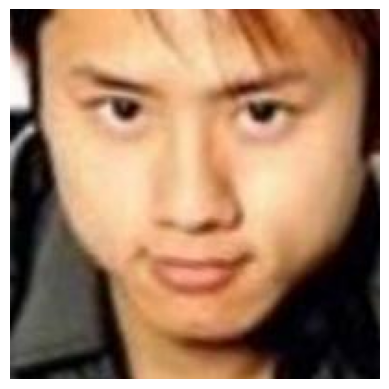

In [9]:
if not df.empty:
    try:
        img = Image.open(df['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print(f"Dataframe is empty, No image is found.")

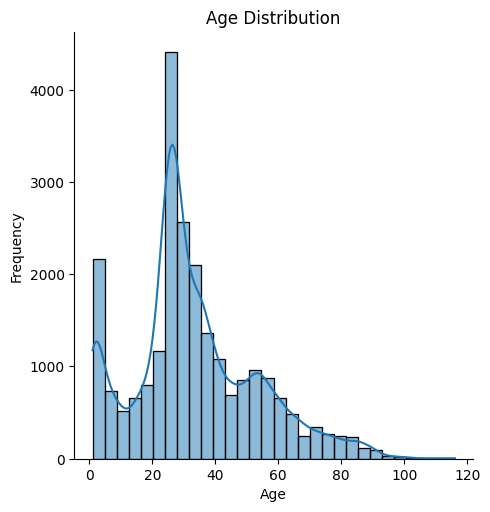

In [10]:
sns.displot(df['age'],kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Feature Extraction

def extract_feature(images):
    features=[]
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128,128), Image.BILINEAR)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape((len(features), 128,128,1))
    return features

In [12]:
x = extract_feature(df['image'])
print(f"X_shape:\t{x.shape}")

100%|██████████| 23708/23708 [03:14<00:00, 122.01it/s]


X_shape:	(23708, 128, 128, 1)


In [13]:
x = x/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
print("shape of y_gender: ", y_gender.shape)
print("Shape of y_age: ",y_age.shape)

shape of y_gender:  (23708,)
Shape of y_age:  (23708,)


In [14]:
input_shape = (128,128,1)
inputs = Input(input_shape)
conv1 = Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(64,kernel_size=(3,3),activation='relu')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(128,kernel_size=(3,3),activation='relu')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(256,kernel_size=(3,3),activation='relu')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2,2))(conv4)
flatten = Flatten()(maxp4)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)
dropout1 = Dropout(0.3)(dense1)
dropout2 = Dropout(0.3)(dense2)
output1 = Dense(1,activation='sigmoid',name='gender_out')(dropout1)
output2 = Dense(1,activation='relu',name='age')(dropout1)
model = Model(inputs=inputs, outputs=[output1,output2])
model.summary()

2025-06-22 16:09:16.111284: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 9216)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,747,906 (10.48 MB)

 Trainable params: 2,747,906 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
y_combined = np.column_stack((y_gender,y_age))
X_train, X_temp, y_combined_train, y_combined_temp = train_test_split(
    x, y_combined, test_size = 0.2 , random_state = 42
)
x_test, x_val, y_combined_test, y_combined_val = train_test_split(X_temp, y_combined_temp, test_size = 0.5, random_state = 42)

In [16]:
y_train_gender, y_train_age = y_combined_train[:,0] , y_combined_train[:,1]
y_test_gender, y_test_age = y_combined_test[:,0], y_combined_test[:,1]
y_val_gender,y_val_age = y_combined_val[:,0], y_combined_val[:,1]

In [17]:
model_path = './best_model.keras'
checkpointer = ModelCheckpoint(
    filepath = model_path,
    monitor = 'val_gender_out_accuracy',
    verbose = 1,
    mode = 'max',
    save_best_only = True
)

In [18]:
from keras.callbacks import LearningRateScheduler
model.compile(loss=['binary_crossentropy','mae'],
    optimizer='adam',
    metrics=['accuracy', 'mae' ])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [19]:
total_images =len(image_paths)
print(f"total number images: {total_images}s")

total number images: 23708s


In [20]:
train_images=len(X_train)
validation_images=len(x_val)
test_images=len(x_test)
print(f"Number of the training images: {train_images}")
print(f"Number of the validation images: {validation_images}")
print(f"Number of the test images: {test_images}")

Number of the training images: 18966
Number of the validation images: 2371
Number of the test images: 2371


In [21]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [22]:
history = model.fit(
    x = X_train,
    y = [y_train_gender, y_train_age],
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val, [y_val_gender, y_val_age]),
    callbacks = [annealer, checkpointer]
)


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - age_loss: 19.4182 - age_mae: 19.4182 - gender_out_accuracy: 0.5087 - gender_out_loss: 0.9333 - loss: 20.3515
Epoch 1: val_gender_out_accuracy improved from -inf to 0.54576, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - age_loss: 19.4014 - age_mae: 19.4014 - gender_out_accuracy: 0.5087 - gender_out_loss: 0.9329 - loss: 20.3343 - val_age_loss: 14.6682 - val_age_mae: 14.6682 - val_gender_out_accuracy: 0.5458 - val_gender_out_loss: 0.6843 - val_loss: 15.3524 - learning_rate: 0.0010
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - age_loss: 14.5809 - age_mae: 14.5809 - gender_out_accuracy: 0.5402 - gender_out_loss: 0.7366 - loss: 15.3176
Epoch 2: val_gender_out_accuracy improved from 0.54576 to 0.70941, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - age_loss: 14.5788 - age_mae: 14.5788 - gender_out_accuracy: 0.5406 - gender_out_loss: 0.7363 - loss: 15.3152 - val_age_loss: 

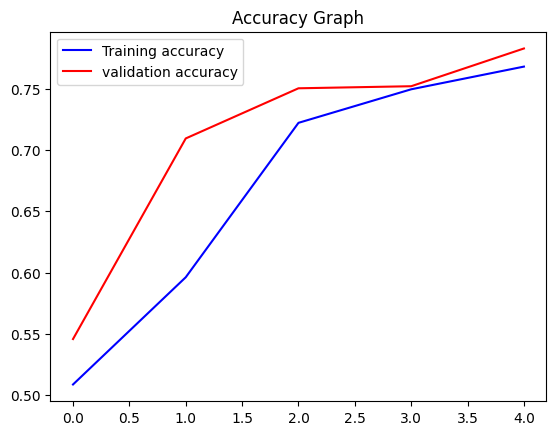

In [23]:
acc=history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc,'b', label='Training accuracy')
plt.plot(epochs, val_acc,'r',label='validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

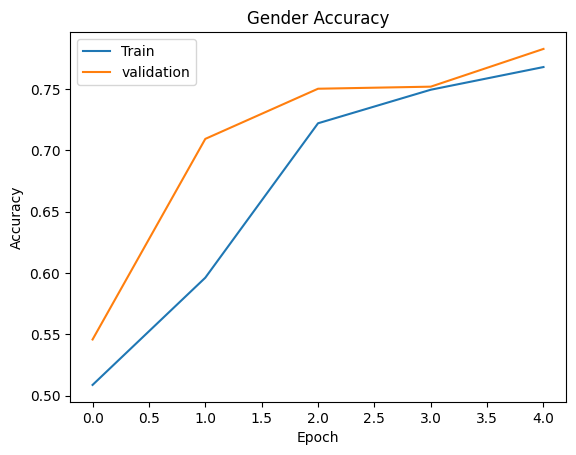

In [24]:
plt.plot(history.history['gender_out_accuracy'])
plt.plot(history.history['val_gender_out_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','validation' ],loc='upper left')
plt.show()

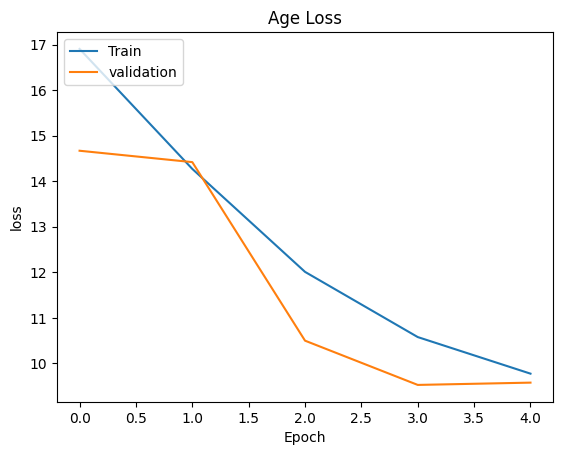

In [27]:
plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Age Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','validation' ], loc='upper left')
plt.show()

In [26]:
print(history.history.keys())


dict_keys(['age_loss', 'age_mae', 'gender_out_accuracy', 'gender_out_loss', 'loss', 'val_age_loss', 'val_age_mae', 'val_gender_out_accuracy', 'val_gender_out_loss', 'val_loss', 'learning_rate'])


In [28]:
image_index = 3000
print(f"original gender:\t{gender_dict[y_gender[image_index]]}\t original Age:\t{y_age[image_index]}")

original gender:	Male	 original Age:	28


In [29]:
pred=model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[int(round(pred[0][0][0]))]
pred_age= round(pred[1][0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Predicted Gender:	 Female	 Predicted Age:	 40


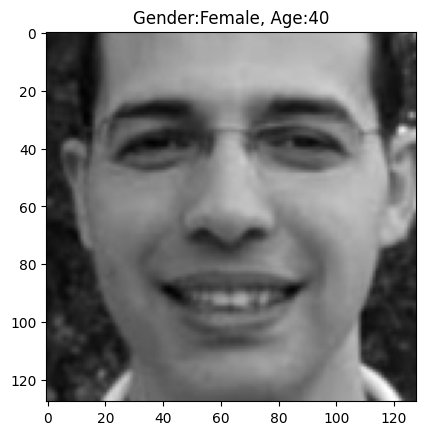

In [34]:
print(f"Predicted Gender:\t {pred_gender}\t Predicted Age:\t {pred_age}")
plt.title(f"Gender:{pred_gender}, Age:{pred_age}")
plt.imshow(x[image_index].reshape(128,128),cmap='gray')
plt.show()